## Dataset : Cornell Movie Review Data

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re
from tqdm.auto import tqdm
import random
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import os
from sklearn.metrics import f1_score, recall_score, precision_score
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from itertools import product
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

[nltk_data] Downloading package stopwords to /home/dimits/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dimits/nltk_data...
[nltk_data] Downloading package punkt to /home/dimits/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#!pip install --upgrade tensorflow

In [3]:
!wget https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz


--2024-02-08 10:36:40--  https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3,0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz’

review_polarity.tar 100%[===================>]   2,98M  1,05MB/s    in 2,8s    

2024-02-08 10:36:43 (1,05 MB/s) - ‘review_polarity.tar.gz’ saved [3127238/3127238]



In [4]:
!tar xvzf review_polarity.tar.gz


txt_sentoken/neg/cv000_29416.txt
txt_sentoken/neg/cv001_19502.txt
txt_sentoken/neg/cv002_17424.txt
txt_sentoken/neg/cv003_12683.txt
txt_sentoken/neg/cv004_12641.txt
txt_sentoken/neg/cv005_29357.txt
txt_sentoken/neg/cv006_17022.txt
txt_sentoken/neg/cv007_4992.txt
txt_sentoken/neg/cv008_29326.txt
txt_sentoken/neg/cv009_29417.txt
txt_sentoken/neg/cv010_29063.txt
txt_sentoken/neg/cv011_13044.txt
txt_sentoken/neg/cv012_29411.txt
txt_sentoken/neg/cv013_10494.txt
txt_sentoken/neg/cv014_15600.txt
txt_sentoken/neg/cv015_29356.txt
txt_sentoken/neg/cv016_4348.txt
txt_sentoken/neg/cv017_23487.txt
txt_sentoken/neg/cv018_21672.txt
txt_sentoken/neg/cv019_16117.txt
txt_sentoken/neg/cv020_9234.txt
txt_sentoken/neg/cv021_17313.txt
txt_sentoken/neg/cv022_14227.txt
txt_sentoken/neg/cv023_13847.txt
txt_sentoken/neg/cv024_7033.txt
txt_sentoken/neg/cv025_29825.txt
txt_sentoken/neg/cv026_29229.txt
txt_sentoken/neg/cv027_26270.txt
txt_sentoken/neg/cv028_26964.txt
txt_sentoken/neg/cv029_19943.txt
txt_sentoken/n

In [5]:
import os
from sklearn.datasets import load_files


dataset_path = 'txt_sentoken'
movie_reviews = load_files(container_path = dataset_path, encoding = 'utf-8')


x = movie_reviews.data            #the data
y = movie_reviews.target          #the labels
z = movie_reviews.target_names    #the names of labels

In [6]:
x[:1]

["arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nyes , the film is 

In [7]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [8]:
z

['neg', 'pos']

## Average Document Length

In [9]:
len(x)

2000

In [10]:
len(x[0])

3126

In [11]:
def average_doc_length(corpus):
    ''' Takes as input a whole corpus
      Returns the average number of words and chars per document '''

    document_word_lengths = [len(doc.split()) for doc in corpus]                            #length of each doc (in words)
    average_doc_length_words = sum(document_word_lengths) / len(document_word_lengths)      #average doc length (in words)

    document_char_lengths = [len(doc) for doc in corpus]                                    #length of each doc (in characters)
    average_doc_length_chars = sum(document_char_lengths) / len(document_char_lengths)      #average doc length (in characters)

    return average_doc_length_words, average_doc_length_chars

In [12]:
#from common import average_doc_length
print("---Before preprocessing---")
avg_length_words, avg_length_chars = average_doc_length(x)
print("Average Document Length (in words):", avg_length_words)
print("Average Document Length (in characters):", avg_length_chars)

---Before preprocessing---
Average Document Length (in words): 746.3405
Average Document Length (in characters): 3893.002


## Pre processing

Let's take a look at the 100 most frequent words:

In [13]:
text = ' '.join(x)
tokens = word_tokenize(text.lower())              #convert to lowercase to treat words case-insensitively
#tokens = [token.lower() for token in x]
word_counts = Counter(tokens)
top_100_words = word_counts.most_common(100)

for word, count in top_100_words:
  print(f"{word}: {count} occurrences")

,: 77717 occurrences
the: 76276 occurrences
.: 65876 occurrences
a: 37995 occurrences
and: 35404 occurrences
of: 33972 occurrences
to: 31772 occurrences
is: 26054 occurrences
in: 21611 occurrences
's: 18128 occurrences
``: 17625 occurrences
it: 16059 occurrences
that: 15912 occurrences
): 11781 occurrences
(: 11664 occurrences
as: 11349 occurrences
with: 10782 occurrences
for: 9918 occurrences
this: 9573 occurrences
his: 9569 occurrences
film: 9443 occurrences
i: 8850 occurrences
he: 8840 occurrences
but: 8604 occurrences
on: 7249 occurrences
are: 7204 occurrences
by: 6218 occurrences
n't: 6217 occurrences
be: 6083 occurrences
an: 5742 occurrences
who: 5680 occurrences
not: 5672 occurrences
movie: 5671 occurrences
one: 5582 occurrences
you: 5286 occurrences
was: 5225 occurrences
have: 5046 occurrences
from: 4987 occurrences
at: 4972 occurrences
they: 4815 occurrences
has: 4811 occurrences
her: 4508 occurrences
all: 4259 occurrences
?: 3771 occurrences
there: 3758 occurrences
so: 3585 o

The english stopwords is a package of 179 words that in general, would not help in a sentiment analysis problem. But, since they include terms that are negative, removing them could prove harmful for our case.

e.g. imagine the phrase "I didn't like the film" to end up "like film".

So, the plan is to remove all the stop words that include negative meaning before the preprocessing.

In [14]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

 From these words, we will decide which ones to keep because in fact they have a meaningful impact in our sentiment analysis problem, as we stated earlier.

In [15]:
set_stop_words = set(stopwords.words('english'))
set_x = set(tokens)
to_keep_words = ['not', "don't", "aren't", "couldn't", "didn't", "doesn't", "hadn't", "hasn't" , "shouldn't", "haven't", "wasn't", "weren't",  "isn't", "doesn"]


In [16]:
stopwords_updated = set(stopwords.words('english')) - set(to_keep_words)
print(len(stopwords.words('english')))
print(len(to_keep_words))
print(len(stopwords_updated))

179
14
165


In [17]:
def pre_process_text(text):
    ''' Function to preprocess text.
     input: initial text
     output: processed text
     Performs pre-processing methods:
        1. Combination to a single document.
        2. Convertion to lowercase.
        3. Lemmatization and stop words extraction
        4. Punctuation removal
        5. Number removal
        6. Single characters removal
        7. Converting multiple spaces to single ones
        '''
    lemmatizer = WordNetLemmatizer()
    all_docs = []

    single_char = re.compile(r'\s+[a-z]\s+')                                          #6. Remove single characters
    multiple_space= re.compile(r'\s+')                                                 #7. Replace multiple space with a single one

    stopwords_updated = set(stopwords.words('english')) - set(to_keep_words)
    for document in tqdm(x):

        combined_text = ' '.join(text)            #1.Combine in one single document

        combined_text = combined_text.lower()    #2. Convert to lowercase
        combined_text = [lemmatizer.lemmatize(word) for word in document.split() if word not in stopwords_updated]  # 3.Lemmatize and remove stop words


        combined_text = ' '.join(combined_text)

        combined_text = ''.join([char for char in combined_text if char not in string.punctuation])   #4.remove punctuation
        combined_text = ''.join([char for char in combined_text if not char.isdigit()])     #5.remove numbers

        res = single_char.sub(combined_text, '')
        res2 = multiple_space.sub(combined_text, ' ')
        all_docs.append(combined_text)

    return all_docs

In [18]:
processed_text = pre_process_text(x)

processed_text[:1]

  0%|          | 0/2000 [00:00<?, ?it/s]

['arnold schwarzenegger icon action enthusiast  since late s  lately film sloppy oneliner getting worse  hard seeing arnold mr  freeze batman robin  especially say ton ice joke  hey got  million  whats matter  arnold signed another expensive blockbuster  cant compare like terminator series  true lie even eraser  called dark thriller  devil  gabriel byrne  come upon earth  impregnate woman  robin tunney  happens every  year  basically destroy world  apparently god chosen one man  one man jericho cane  arnold   help trusty sidekick  kevin pollack   stop nothing let devil take world  part actually absurd  would fit right dogma  yes  film weak  better blockbuster right  sleepy hollow   make world not enough look like  star film  anyway  definitely doesnt seem like arnold movie  wasnt type film see  sure gave u chuckle well known oneliner  seemed confused character film going  understandable  especially ending changed according source  aside form  still walked  much like past film  im sorry

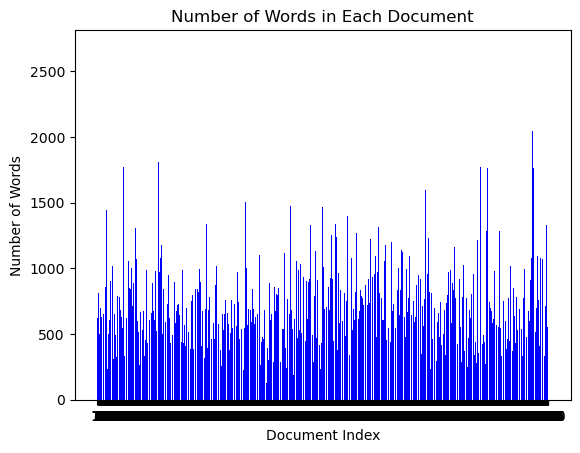

In [19]:
word_counts = [len(doc.split()) for doc in x]

# Plotting
plt.bar(range(len(word_counts)), word_counts, color='blue')
plt.xlabel('Document Index')
plt.ylabel('Number of Words')
plt.title('Number of Words in Each Document')
plt.xticks(range(len(word_counts)), range(1, len(word_counts)+1))
plt.show()

In [20]:
print("---After preprocessing---")
avg_length_words_after, avg_length_chars_after = average_doc_length(processed_text)
print("Average Document Length (in words):", avg_length_words)
print("Average Document Length (in characters):", avg_length_chars)

---After preprocessing---
Average Document Length (in words): 746.3405
Average Document Length (in characters): 3893.002


## Splitting into training set (60%), development set (20%) and test set (20%)

In [21]:
X_train, X_temp, y_train, y_temp = train_test_split(processed_text, y, test_size=0.4, random_state=17)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=25)

training_text = ' '.join(X_train)                    #Flatten into a single string
development_text = ' '.join(X_dev)
test_text = ' '.join(X_test)

training_words = training_text.split()
development_words = development_text.split()
test_words = test_text.split()

training_vocab = set(training_words)
development_vocab = set(development_words)
test_vocab = set(test_words)

In [22]:
print("Training set size (in documents): ", len(y_train))
print("Development set size (in documents): ", len(y_dev))
print("Test set size (in documents): ", len(y_test))
print("Full size (sanity check): ", len(y_train) + len(y_dev) + len(y_test))
print("---------------------------------")
print("Training vocabulary size (in words): " , len(training_vocab))
print("Development vocabulary size (in words): ", len(development_vocab))
print("Test vocabulary size (in words): ", len(test_vocab))
print("Full vocabulary size (in words): ", len(training_vocab) + len(development_vocab) + len(test_vocab))

Training set size (in documents):  1200
Development set size (in documents):  400
Test set size (in documents):  400
Full size (sanity check):  2000
---------------------------------
Training vocabulary size (in words):  33949
Development vocabulary size (in words):  19699
Test vocabulary size (in words):  19872
Full vocabulary size (in words):  73520


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2),                                        #Using unigram and bigram tf-idf features
                             max_features = 5000, sublinear_tf=True)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_dev_tfidf = vectorizer.transform(X_dev)
X_test_tfidf = vectorizer.transform(X_test)

print("Shape (training data): ", X_train_tfidf.shape)
print("Shape (development data): ", X_dev_tfidf.shape)
print("Shape (test data): ", X_test_tfidf.shape)

Shape (training data):  (1200, 5000)
Shape (development data):  (400, 5000)
Shape (test data):  (400, 5000)


Below we can see that X_test_tfidf is a sparse array, keeping only the non-zero elements. We demonstrate all the elements in the first document with their corresponding TFIDF weights.

In [24]:
print("(#Doc,col index)     weight")
print("--------------------------------------------")
print(X_test_tfidf[0, :])

(#Doc,col index)     weight
--------------------------------------------
  (0, 4978)	0.08671052066324904
  (0, 4976)	0.03671538334914884
  (0, 4924)	0.10045276741535573
  (0, 4847)	0.058129549966272086
  (0, 4825)	0.03312626408448193
  (0, 4781)	0.16012186931900993
  (0, 4655)	0.10750369282883378
  (0, 4600)	0.04781179045415405
  (0, 4529)	0.06325658248428882
  (0, 4495)	0.027830009808342326
  (0, 4471)	0.0850404565974127
  (0, 4392)	0.05126888044130781
  (0, 4357)	0.06788837492974621
  (0, 4296)	0.10418068147802131
  (0, 4295)	0.06913879445268362
  (0, 4252)	0.08901034885433064
  (0, 4220)	0.03231945245469888
  (0, 4198)	0.08464341657312996
  (0, 4173)	0.043602750222211
  (0, 4129)	0.10550283215887456
  (0, 4127)	0.09260094687406277
  (0, 4108)	0.06090977686007874
  (0, 4094)	0.042223783831714615
  (0, 4087)	0.07342693311508709
  (0, 4084)	0.1523967192627124
  :	:
  (0, 602)	0.05994739128863232
  (0, 588)	0.10418068147802131
  (0, 586)	0.048946168175341885
  (0, 547)	0.182019574412922

In [25]:
x_train_tfidf_array = X_train_tfidf.toarray()                   #from sparse to dense
x_dev_tfidf_array = X_dev_tfidf.toarray()
x_test_tfidf_array = X_test_tfidf.toarray()


## Reducing dimensionality using SVD (from 5000 ---> 500 features)

In [26]:
svd = TruncatedSVD(n_components=500, random_state=4321)
X_train_svd = svd.fit_transform(x_train_tfidf_array)
X_dev_svd = svd.transform(x_dev_tfidf_array)
X_test_svd = svd.transform(x_test_tfidf_array)

print("Shape (training data) after SVD: ", X_train_svd.shape)
print("Shape (development data) after SVD: ", X_dev_svd.shape)
print("Shape (test data) after SVD: ", X_test_svd.shape)

Shape (training data) after SVD:  (1200, 500)
Shape (development data) after SVD:  (400, 500)
Shape (test data) after SVD:  (400, 500)


In [27]:
len(X_test_svd[0,:]) == 500     #Sanity check if the dimension is 500

True

## Dummy Classifier

In [28]:
dummy_clf = DummyClassifier(strategy="most_frequent") #assigns the most frequent class
dummy_clf.fit(X_train_svd, y_train)


y_dev_pred = dummy_clf.predict(X_dev_svd)

#classification report -- Development set
print("Classification Report on Development Set:")
print(classification_report(y_dev, y_dev_pred, target_names=z))

print("-----------------------------------------------------")

#classification report -- Training set
y_train_pred = dummy_clf.predict(X_train_svd)
print("Classification Report on Training Set:")
print(classification_report(y_train, y_train_pred, target_names=z))

print("-----------------------------------------------------")

#classification report -- Test set
y_test_pred = dummy_clf.predict(X_test_svd)
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred, target_names=z))

Classification Report on Development Set:
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00       202
         pos       0.49      1.00      0.66       198

    accuracy                           0.49       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.49      0.33       400

-----------------------------------------------------
Classification Report on Training Set:
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00       589
         pos       0.51      1.00      0.67       611

    accuracy                           0.51      1200
   macro avg       0.25      0.50      0.34      1200
weighted avg       0.26      0.51      0.34      1200

-----------------------------------------------------
Classification Report on Test Set:
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00       209
         pos 

/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/d

## Logistic Regression

In [29]:
parameters = {
    'solver': ['liblinear', 'saga'],  #solvers to try
    'penalty': ['l1', 'l2', 'elasticnet'],  #reguralization penalties
    'C': [0.001, 0.01, 0.1, 1, 10],  #inverse of regularization strength
}

log_clf = LogisticRegression()
log_grid_clf = GridSearchCV(log_clf, parameters, cv=5, scoring='accuracy', verbose=1)

log_grid_clf.fit(X_train_svd, y_train)
print("Best hyperparameters:", log_grid_clf.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/dimits/anaconda3/envs/tf

Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [30]:
best_clf = log_grid_clf.best_estimator_
best_clf

LogisticRegression(C=10, penalty='l1', solver='liblinear')

In [31]:
best_clf.fit(X_train_svd, y_train)

#classification report -- Development set
y_dev_pred = best_clf.predict(X_dev_svd)
print("\nClassification Report on Development Set:")
print(classification_report(y_dev, y_dev_pred, target_names=z))

print("-----------------------------------------------------")

#classification report -- Training set
y_train_pred = best_clf.predict(X_train_svd)
print("Classification Report on Training Set:")
print(classification_report(y_train, y_train_pred, target_names=z))

print("-----------------------------------------------------")

#classification report -- Test set
y_test_pred = best_clf.predict(X_test_svd)
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred, target_names=z))


Classification Report on Development Set:
              precision    recall  f1-score   support

         neg       0.87      0.82      0.85       202
         pos       0.83      0.88      0.85       198

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400

-----------------------------------------------------
Classification Report on Training Set:
              precision    recall  f1-score   support

         neg       1.00      1.00      1.00       589
         pos       1.00      1.00      1.00       611

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

-----------------------------------------------------
Classification Report on Test Set:
              precision    recall  f1-score   support

         neg       0.87      0.86      0.86       209
         pos

## Creating one-hot vectors

In [32]:
lb = LabelBinarizer()
target_list = z

y_train_1_hot = lb.fit_transform([target_list[x] for x in y_train])
y_dev_1_hot = lb.transform([target_list[x] for x in y_dev])

print('y_train_1_hot[0]: {}'.format(y_train_1_hot[0]))

y_train_1_hot[0]: [0]


In [33]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]

        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)

        _val_f1 = f1_score(val_targ, val_predict, average="weighted",
                           zero_division=1)
        _val_recall = recall_score(val_targ, val_predict, average="weighted",
                                   zero_division=1)
        _val_precision = precision_score(val_targ, val_predict, average="weighted",
                                         zero_division=1)

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

In [59]:
def create_MLP(input_size, activate_func,prob,hid_layers_size, optimizer_alg, bs_size, num_epochs):
    model = Sequential()
    model.add(Dense(input_size, input_dim = X_train_svd.shape[1], activation = activate_func))
    model.add(Dropout(prob))
    model.add(Dense(hid_layers_size, activation = activate_func))
    model.add(Dropout(prob))
    # needed an output layer with sigmoid (pdf-like output) with no dropout after it
    model.add(Dense(1,  activation='sigmoid'))
    print(model.summary())

    model.compile(
        loss='binary_crossentropy',
        optimizer = optimizer_alg,
        metrics = ["accuracy"]
    )
    if not os.path.exists('./checkpoints'):
        os.makedirs('./checkpoints')
    model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=["accuracy"]
    )

    if not os.path.exists('./checkpoints'):
      os.makedirs('./checkpoints')

    checkpoint = ModelCheckpoint(
    'checkpoints/weights.hdf5',
    monitor='val_accuracy',
    mode='max',
    verbose=2,
    save_best_only=True,
    save_weights_only=True
    )

    start_training_time = time.time()
    history = model.fit(
      X_train_svd,
      y_train_1_hot,
      validation_data=(X_dev_svd, y_dev_1_hot),
      batch_size=bs_size,
      epochs=num_epochs,
      shuffle=True,
      callbacks=[Metrics(valid_data=(X_dev_svd, y_dev_1_hot)), checkpoint]
      )
    end_training_time = time.time()

    print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} sec\n')

    return history, model



## Setting the hyperparameters

In [60]:
parameter_grid = {
    'input_size': [256, 512],
    'activate_func': ['relu', 'sigmoid'],
    'prob': [0.3, 0.4, 0.5],
    'hid_layers_size': [2, 10, 50],
    'optimizer_alg': ['adam', 'sgd'],
    'bs_size': [32, 64, 128],
    'num_epochs': [10, 40, 100]
}

In [70]:

parameter_grid = {                          #Just to save time (to be deleted later)
    'input_size' : [1],
    'activate_func' : ['relu'],
    'prob' : [0.5],
    'hid_layers_size' : [2],
    'optimizer_alg' : ['adam'],
    'bs_size': [32],
    'num_epochs': [100]
}


In [71]:
param_combinations = list(product(*parameter_grid.values()))            #all possible combinations
results = []
for params in tqdm(param_combinations):

    input_size, activate_func, prob, hid_layers_size, optimizer_alg, bs_size, num_epochs = params          #unpack params
    history, model = create_MLP(input_size, activate_func, prob, hid_layers_size, optimizer_alg, bs_size, num_epochs)
    dev_loss, dev_accuracy = model.evaluate(X_dev_svd, y_dev_1_hot)

    results.append({
        'params': params,
        'history': history,
        'model': model,

    })


best_result = max(results, key=lambda x: max(x['history'].history['val_accuracy']))               #Find the set of parameters with the best validation accuracy

input_size = best_result['params'][0]
activate_func = best_result['params'][1]
dropout_prob = best_result['params'][2]
hid_layer_size = best_result['params'][3]
optimizer_alg = best_result['params'][4]
batch_size = best_result['params'][5]
num_epochs = best_result['params'][6]

  0%|          | 0/1 [00:00<?, ?it/s]

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1)                 501       
                                                                 
 dropout_14 (Dropout)        (None, 1)                 0         
                                                                 
 dense_17 (Dense)            (None, 2)                 4         
                                                                 
 dropout_15 (Dropout)        (None, 2)                 0         
                                                                 
 dense_18 (Dense)            (None, 1)                 3         
                                                                 
Total params: 508 (1.98 KB)
Trainable params: 508 (1.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
13/13 [

In [72]:
print("---Best Hyperparameters---")
print("Input size:", input_size)
print("Activation Function:", activate_func)
print("Dropout Probability:", dropout_prob)
print("Hidden Layer Size:", hid_layer_size)
print("Optimizer Algorithm:", optimizer_alg)
print("Batch Size:", batch_size)
print("Number of Epochs:", num_epochs)

---Best Hyperparameters---
Input size: 1
Activation Function: relu
Dropout Probability: 0.5
Hidden Layer Size: 2
Optimizer Algorithm: adam
Batch Size: 32
Number of Epochs: 100


In [73]:
history, best_model = create_MLP(input_size, activate_func, dropout_prob, hid_layer_size, optimizer_alg, batch_size, num_epochs)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 1)                 501       
                                                                 
 dropout_16 (Dropout)        (None, 1)                 0         
                                                                 
 dense_20 (Dense)            (None, 2)                 4         
                                                                 
 dropout_17 (Dropout)        (None, 2)                 0         
                                                                 
 dense_21 (Dense)            (None, 1)                 3         
                                                                 
Total params: 508 (1.98 KB)
Trainable params: 508 (1.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
13/13 [

In [74]:
#classification report -- Training set
print("Classification report -- Training set")
pred = np.argmax(best_model.predict(X_train_svd), axis = -1)                  #use np.argmax() because we are handling binary data
print(classification_report(y_train, pred, target_names = z))

Classification report -- Training set
38/38 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         neg       0.49      1.00      0.66       589
         pos       0.00      0.00      0.00       611

    accuracy                           0.49      1200
   macro avg       0.25      0.50      0.33      1200
weighted avg       0.24      0.49      0.32      1200



/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
#classification report -- Development set
print("Classification report -- Development set")
pred = np.argmax(best_model.predict(X_dev_svd), axis = -1)                  #use np.argmax() because we are handling binary data
print(classification_report(y_dev, pred, target_names = z))

Classification report -- Development set
13/13 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         neg       0.51      1.00      0.67       202
         pos       0.00      0.00      0.00       198

    accuracy                           0.51       400
   macro avg       0.25      0.50      0.34       400
weighted avg       0.26      0.51      0.34       400



/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
#classification report -- Test set
print("Classification report -- Test set")
pred = np.argmax(best_model.predict(X_test_svd), axis = -1)                  #use np.argmax() because we are handling binary data
print(classification_report(y_test, pred, target_names = z))

Classification report -- Test set
13/13 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         neg       0.52      1.00      0.69       209
         pos       0.00      0.00      0.00       191

    accuracy                           0.52       400
   macro avg       0.26      0.50      0.34       400
weighted avg       0.27      0.52      0.36       400



/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Visualize Model's Training History

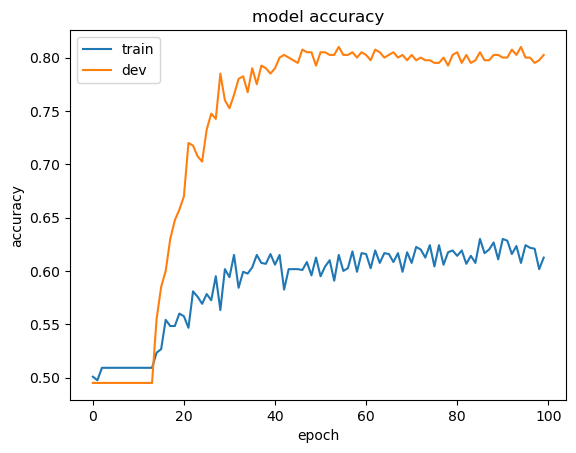

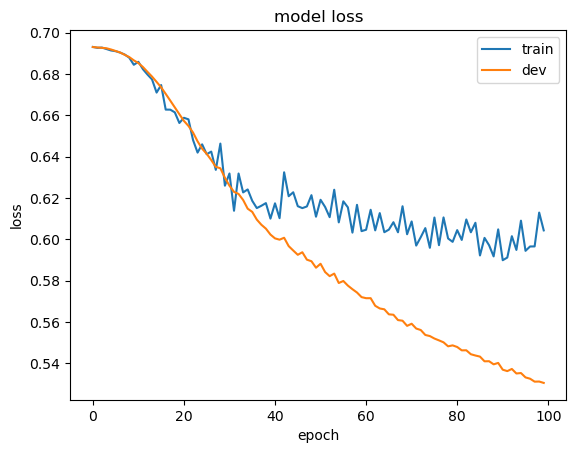

In [77]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()